# Model regresji: przewidywanie `Life expectancy`

Cel: zbudować i ocenić model regresji przewidujący oczekiwaną długość życia (*Life expectancy*) na podstawie zmiennych zdrowotnych, ekonomicznych i społecznych z pliku CSV.

Notebook prowadzi krok po kroku (wersja uproszczona, w stylu MED1–MED6):
1) wczytanie danych, 2) kontrola braków i typów, 3) proste przygotowanie danych (imputacja + standaryzacja + One-Hot dla `Status`), 4) trenowanie modeli liniowych (LinearRegression, Ridge), 5) metryki i prosta walidacja krzyżowa, 6) analiza błędów i interpretacja współczynników, 7) zapis modelu.

Założenie (domyślne): **nie używamy `Country` jako cechy**, żeby uniknąć “identyfikowania kraju” i przeuczenia; zostawiamy `Year`, `Status` i pozostałe zmienne numeryczne.

In [3]:
# 1) Ustawienia środowiska i import bibliotek
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression, Ridge

# Ustawienia czytelności
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 140)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

sns.set_theme(style="whitegrid")

print("OK: biblioteki załadowane")

OK: biblioteki załadowane


## 2) Wczytanie CSV i szybka walidacja danych

Uwaga: w oryginalnym zbiorze zdarzają się spacje na końcu nazw kolumn (np. `Life expectancy `). Poniżej **czyścimy nazwy kolumn** przez `.str.strip()` i dopiero potem wybieramy target.

In [4]:
# 2) Wczytanie CSV i szybka walidacja danych

CSV_PATH = Path("Life Expectancy Data.csv")  # plik jest w katalogu projektu

if not CSV_PATH.exists():
    raise FileNotFoundError(f"Nie znaleziono pliku: {CSV_PATH.resolve()}")

df = pd.read_csv(CSV_PATH)

# standaryzacja nazw kolumn (w zbiorze zdarzają się spacje na końcu)
df.columns = df.columns.str.strip()

print("Wczytano df:")
print("- shape:", df.shape)
display(df.head())

# szybka sanity-check
print("\nKolumny:", list(df.columns))
print("\nPrzykładowe kraje:", df["Country"].dropna().unique()[:5])
print("Zakres lat:", df["Year"].min(), "-", df["Year"].max())

Wczytano df:
- shape: (2938, 22)


,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,19.1,83,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,86,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,18.1,89,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,17.6,93,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,17.2,97,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5



Kolumny: ['Country', 'Year', 'Status', 'Life expectancy', 'Adult Mortality', 'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles', 'BMI', 'under-five deaths', 'Polio', 'Total expenditure', 'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'thinness  1-19 years', 'thinness 5-9 years', 'Income composition of resources', 'Schooling']

Przykładowe kraje: ['Afghanistan' 'Albania' 'Algeria' 'Angola' 'Antigua and Barbuda']
Zakres lat: 2000 - 2015


## 3) Podgląd struktury: typy kolumn, braki danych, duplikaty

W tym kroku:
- sprawdzamy typy kolumn,
- liczymy braki danych (procentowo),
- sprawdzamy duplikaty,
- robimy prosty wykres procentu braków.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10  BMI                              2904 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  Polio               

None


Kolumny z brakami (top 15):


,missing_%,missing_count
Population,22.19,652
Hepatitis B,18.82,553
GDP,15.25,448
Total expenditure,7.69,226
Alcohol,6.60,194
Income composition of resources,5.68,167
Schooling,5.55,163
thinness 5-9 years,1.16,34
thinness 1-19 years,1.16,34
BMI,1.16,34



Duplikaty wierszy: 0

Kolumny kategoryczne: ['Country', 'Status']
- Country: 193 unikalnych wartości
- Status: 2 unikalnych wartości


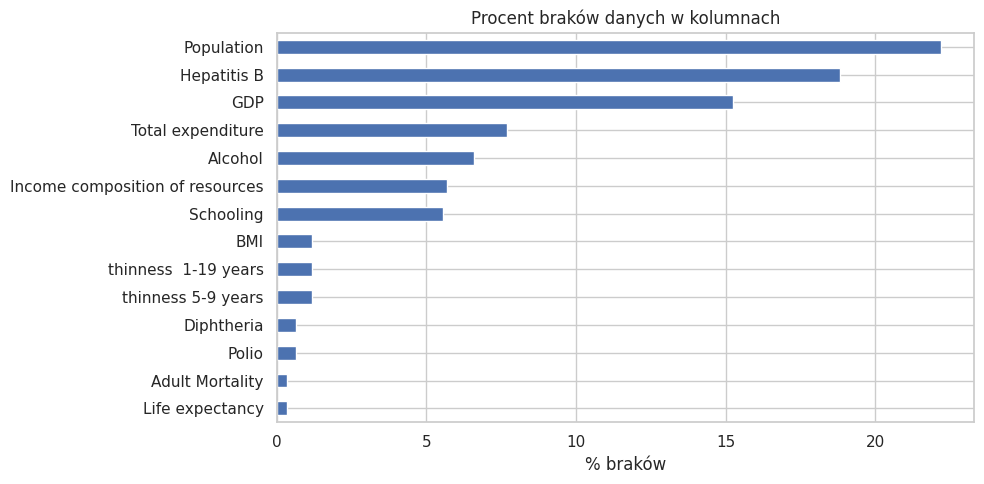

In [5]:
# 3) Typy, braki, duplikaty

display(df.info())

missing_frac = df.isna().mean().sort_values(ascending=False)
missing_tbl = (missing_frac * 100).round(2).to_frame("missing_%")
missing_tbl["missing_count"] = df.isna().sum()
missing_tbl = missing_tbl[missing_tbl["missing_count"] > 0]

print("\nKolumny z brakami (top 15):")
display(missing_tbl.head(15))

dup_count = df.duplicated().sum()
print(f"\nDuplikaty wierszy: {dup_count}")

cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
print("\nKolumny kategoryczne:", cat_cols)
for c in cat_cols:
    print(f"- {c}: {df[c].nunique(dropna=True)} unikalnych wartości")

# wykres procentu braków
if len(missing_tbl) > 0:
    plt.figure(figsize=(10, 5))
    missing_tbl["missing_%"].sort_values(ascending=True).plot(kind="barh")
    plt.title("Procent braków danych w kolumnach")
    plt.xlabel("% braków")
    plt.tight_layout()
    plt.show()

## Braki danych: co z nimi robimy?

W EDA wyszło, że usunięcie wierszy z brakami wycina ~44% danych i może biasować próbę (kraje z lepszą sprawozdawczością). Dlatego tutaj:

- **Nie usuwamy wierszy** z brakami w cechach (poza brakami w samym `y`).
- Uzupełniamy braki w danych w prosty sposób:
  - kolumny liczbowe → **mediana**,
  - `Status` → **najczęstsza wartość** + zamiana na kolumny 0/1 (One-Hot).

Opcjonalnie (zgodnie z narracją EDA o "wartościach z lat poprzednich"): można zrobić uzupełnianie **w obrębie kraju po czasie** (forward-fill/back-fill). To ma sens, ale trzeba uważać na wyciek informacji; jeśli chcesz, zrobimy to jako osobny eksperyment (train i test osobno).

In [6]:
def country_time_impute(frame: pd.DataFrame, numeric_columns: list[str]) -> pd.DataFrame:
    out = frame.copy()
    if "Country" not in out.columns or "Year" not in out.columns:
        return out

    out = out.sort_values(["Country", "Year"]).reset_index(drop=True)

    # forward-fill i backward-fill w obrębie kraju
    out[numeric_columns] = (
        out.groupby("Country", as_index=False)[numeric_columns]
           .apply(lambda g: g.ffill().bfill())
           .reset_index(drop=True)
    )

    return out
print ('Gotowe!')

Gotowe!


## 4) Wybór zmiennej celu (target) i podział na X/y

Zmienna celu: **`Life expectancy`**.

Zgodnie z poprzednia analizą: **nie używamy `Country` jako cechy** (żeby nie robić modelu „rozpoznaj kraj”). `Country` zostaje tylko jako ewentualny klucz do analiz/eksperymentów z imputacją po czasie.

In [7]:
# 4) Target oraz X/y

TARGET_COL = "Life expectancy"

if TARGET_COL not in df.columns:
    raise KeyError(f"Nie ma kolumny targetu '{TARGET_COL}'. Dostępne: {list(df.columns)}")

# y musi być liczbowe
y = pd.to_numeric(df[TARGET_COL], errors="coerce")

# X: wszystkie kolumny poza targetem, ale bez Country
DROP_COLS = ["Country"]
X = df.drop(columns=[TARGET_COL] + [c for c in DROP_COLS if c in df.columns])

print("X shape:", X.shape)
print("y shape:", y.shape)

# szybki podgląd
print("\nX dtypes (top 10):")
print(X.dtypes.head(10))
print("\ny missing %:", round(y.isna().mean() * 100, 2))

X shape: (2938, 20)
y shape: (2938,)

X dtypes (top 10):
Year                        int64
Status                     object
Adult Mortality           float64
infant deaths               int64
Alcohol                   float64
percentage expenditure    float64
Hepatitis B               float64
Measles                     int64
BMI                       float64
under-five deaths           int64
dtype: object

y missing %: 0.34


## 5) Podział train/test (z kontrolą losowości)

Żeby porównywać modele uczciwie, robimy stały podział `train_test_split`.


In [8]:
# 5) train/test split (uprościliśmy: bez stratyfikacji po binach y)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    shuffle=True,
 )

print("Train:", X_train.shape, "Test:", X_test.shape)
print("y_train missing %:", round(y_train.isna().mean() * 100, 2))
print("y_test missing %:", round(y_test.isna().mean() * 100, 2))

# Jeśli target ma braki, usuwamy je TYLKO z y i odpowiadających wierszy X w danym zbiorze.
train_mask = y_train.notna()
test_mask = y_test.notna()
X_train = X_train.loc[train_mask]
y_train = y_train.loc[train_mask]
X_test = X_test.loc[test_mask]
y_test = y_test.loc[test_mask]

print("Po usunięciu braków w y:")
print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (2350, 20) Test: (588, 20)
y_train missing %: 0.34
y_test missing %: 0.34
Po usunięciu braków w y:
Train: (2342, 20) Test: (586, 20)


## 6) Przygotowanie danych: imputacja + standaryzacja + One-Hot dla `Status`

Do zmiany

Cel tego kroku jest bardzo prosty:
- zamienić `X_train` i `X_test` na macierze liczbowe (`X_train_t`, `X_test_t`),
- zrobić to **bez wycieku informacji**: wszystko dopasowujemy tylko na train, a potem tylko transformujemy test.

Co robimy dokładnie:
- **numeryczne**: `SimpleImputer(median)` → `StandardScaler()`,
- **kategoryczne** (tylko `Status`): `SimpleImputer(most_frequent)` → `OneHotEncoder(handle_unknown='ignore')`.

In [27]:
# 6) Przygotowanie danych (ręczne fit/transform) – wersja uproszczona z komentarzami

# Wybór kolumn
# - numeryczne: wszystkie kolumny typu number
# - kategoryczne: w praktyce zostawiamy tylko Status (inne obiekty często są kluczami/ID)
numeric_features = X_train.select_dtypes(include=["number"]).columns.tolist()
categorical_features = ['Status']

# Definiujemy proste transformatory 
num_imputer = SimpleImputer(strategy="median")
scaler = StandardScaler()

cat_imputer = SimpleImputer(strategy="most_frequent")

ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

In [28]:
def fit_preprocess(X_train: pd.DataFrame) -> dict:
    """Dopasuj transformatory TYLKO na zbiorze treningowym."""
    bundle: dict = {}

    # --- część numeryczna ---
    # 1) imputacja braków medianą
    # 2) standaryzacja (średnia=0, std=1) – ważne dla modeli z regularyzacją (Ridge)
    bundle["numeric_features"] = numeric_features
    bundle["num_imputer"] = num_imputer.fit(X_train[numeric_features])
    X_num = bundle["num_imputer"].transform(X_train[numeric_features])
    bundle["scaler"] = scaler.fit(X_num)

    # --- część kategoryczna (Status) ---
    # pomysl Lukaszu tutaj czy nie daloby tego uproscic po porstu zamieniajac developed np na 1 a developing na 0
    bundle["categorical_features"] = categorical_features
    bundle["cat_imputer"] = cat_imputer.fit(X_train[categorical_features])
    X_cat = bundle["cat_imputer"].transform(X_train[categorical_features])
    bundle["ohe"] = ohe.fit(X_cat)

    # Zapamiętujemy nazwy cech po transformacji (przydaje się do interpretacji współczynników)
    num_names = np.array(numeric_features, dtype=object)
    cat_names = bundle["ohe"].get_feature_names_out(categorical_features).astype(object)

    bundle["feature_names"] = np.concatenate([num_names, cat_names])

    return bundle

In [29]:
def transform_preprocess(bundle: dict, X: pd.DataFrame) -> np.ndarray:
    """Transformuj X: imputacja + skalowanie + OneHot."""
    # --- numeryczne ---
    X_num = bundle["num_imputer"].transform(X[bundle["numeric_features"]])
    X_num = bundle["scaler"].transform(X_num)

    # --- kategoryczne ---
    X_cat = bundle["cat_imputer"].transform(X[bundle["categorical_features"]])
    X_cat = bundle["ohe"].transform(X_cat)


    # Sklejamy w jedną macierz cech
    X_t = np.hstack([X_num, X_cat])
    return X_t

In [31]:
# Fit na train -> transform train/test
preprocess_bundle = fit_preprocess(X_train)
X_train_t = transform_preprocess(preprocess_bundle, X_train)
X_test_t = transform_preprocess(preprocess_bundle, X_test)

print("- X_train_t:", X_train_t.shape)
print("- X_test_t:", X_test_t.shape)
print("- liczba cech po transformacji:", len(preprocess_bundle["feature_names"]))

- X_train_t: (2342, 21)
- X_test_t: (586, 21)
- liczba cech po transformacji: 21


## 7) Dobór cech: lista cech po przygotowaniu danych

Zamiast zaawansowanego doboru cech (SelectKBest itp.), robimy tu tylko rzecz potrzebną do raportu:
- wypisujemy **jakie cechy faktycznie trafiają do modelu** po przygotowaniu danych (po One-Hot),
- dzięki temu w kroku 12 możemy sensownie interpretować współczynniki modelu.

In [ ]:
# 7) "Dobór cech" – wersja uproszczona
#przemysl sens tego

# Nie wybieramy automatycznie podzbioru cech.
# Po prostu sprawdzamy, jakie kolumny (po preprocessingu) wchodzą do modelu.
feature_names = np.array(preprocess_bundle.get("feature_names", []), dtype=object)

print(f"liczba cech: {len(feature_names)}")

# Dla czytelności pokazujemy pierwsze N nazw
display(pd.DataFrame({"feature": feature_names}))

liczba cech: 21


,feature
0,Year
1,Adult Mortality
2,infant deaths
3,Alcohol
4,percentage expenditure
5,Hepatitis B
6,Measles
7,BMI
8,under-five deaths
9,Polio


## 8) Funkcja ewaluacji (MAE / RMSE / $R^2$)

W kroku 8 definiujemy pomocniczą funkcję `evaluate_estimator(...)`, która robi zawsze to samo dla dowolnego modelu regresji z biblioteki scikit-learn:

1) **uczy model** na zbiorze treningowym (`model.fit(X_train_t, y_train)`),
2) **robi predykcje** na teście (`model.predict(X_test_t)`),
3) **liczy metryki** i zwraca je jako słownik (łatwo z tego zrobić tabelę wyników).

Metryki, których używamy:
- **MAE** (*Mean Absolute Error*): średnia wartość $|y - \hat{y}|$. Jednostka taka sama jak target (lata). Im mniejsze, tym lepiej.
- **RMSE** (*Root Mean Squared Error*): $\sqrt{\mathrm{MSE}}$. Mocniej karze duże błędy niż MAE. Też w jednostce lat. Im mniejsze, tym lepiej.
- **$R^2$** (*współczynnik determinacji*): w uproszczeniu, jaka część wariancji targetu jest wyjaśniona przez model. Im bliżej 1, tym lepiej (0 to poziom „średniej”, wartości ujemne oznaczają bardzo słaby model).

Co dokładnie zostało dodane:
- Funkcję `evaluate_estimator(...)` w komórce 18 (to jest nasz własny helper, nie funkcja z biblioteki).
- Użycie gotowych funkcji metryk z `sklearn.metrics`: `mean_absolute_error`, `mean_squared_error`, `r2_score`.

Uwaga: w kroku 10 robimy osobno **walidację krzyżową** na train (`cross_val_score`) i tam liczymy RMSE (przez `scoring='neg_root_mean_squared_error'`). To jest dodatkowa ocena stabilności modelu, niezależna od pojedynczego test-splita.

In [34]:
# 8) Ewaluacja – bez Pipeline

# Własna funkcja pomocnicza do porównywania modeli.
# Działa dla dowolnego regresora ze scikit-learn, który ma metody: fit() i predict().
def evaluate_estimator(model, X_train_t, X_test_t, y_train, y_test, name: str) -> dict:
    # 1) trening na zbiorze treningowym
    model.fit(X_train_t, y_train)

    # 2) predykcja na zbiorze testowym
    y_pred = model.predict(X_test_t)

    # 3) metryki jakości (im mniejsze MAE/RMSE tym lepiej; im większe R2 tym lepiej)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    return {
        "model": name,
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2,
    }

## 9) Modele: dlaczego takie?

Wybór modeli opiera się na wnioskach z EDA:

- **Zależności są w dużej mierze liniowe** (korelacje + wykresy punktowe), więc startujemy od **regresji liniowej**.
- Jest sporo **współzależnych cech** (np. szczepienia korelują), co może destabilizować współczynniki w czystej regresji liniowej.
- Dlatego jako model „docelowy” bierzemy **Ridge Regression (L2)** – nadal liniowy, ale bardziej stabilny.

Nie używamy `Pipeline`: przygotowanie danych robimy osobno (fit na train → transform train/test), a modele trenujemy na macierzy cech po transformacji.

In [36]:
# 8) LinearRegression + Ridge – uproszczone (bez GridSearchCV)
results = []

# LinearRegression
lin_model = LinearRegression()
results.append(evaluate_estimator(lin_model, X_train_t, X_test_t, y_train, y_test, "LinearRegression"))

# Ridge z jednym, stałym alpha (prosty wybór do raportu)
ridge_best = Ridge(alpha=1.0, random_state=RANDOM_STATE)
results.append(evaluate_estimator(ridge_best, X_train_t, X_test_t, y_train, y_test, "Ridge(alpha=1.0)"))

results_df = pd.DataFrame(results).sort_values("RMSE")
display(results_df)

# Wybór najlepszego modelu wg RMSE na teście
best_name = results_df.iloc[0]["model"]
best_model = ridge_best if best_name.startswith("Ridge") else lin_model
print("Najlepszy wg RMSE (test):", best_name)

,model,MAE,RMSE,R2
0,LinearRegression,2.846407,3.891677,0.825779
1,Ridge(alpha=1.0),2.848434,3.895869,0.825404


Najlepszy wg RMSE (test): LinearRegression


## 10) Walidacja krzyżowa i raport metryk

Walidacja krzyżowa (np. 5-fold) pozwala sprawdzić stabilność wyniku.

$$RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i-\hat{y}_i)^2}$$

In [37]:
# 10) Prosta walidacja krzyżowa (5-fold) dla najlepszego modelu

# Liczymy tylko RMSE, żeby kod był prosty.
cv_scores = cross_val_score(
    best_model,
    X_train_t,
    y_train,
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
 )

rmse_scores = -cv_scores
print("CV (5-fold) – RMSE:")
print("- średnia:", float(rmse_scores.mean()))
print("- odch. std:", float(rmse_scores.std()))
display(pd.DataFrame({"RMSE": rmse_scores}))

CV (5-fold) – RMSE:
- średnia: 4.129119134573142
- odch. std: 0.13229751005497212


,RMSE
0,4.223331
1,3.929084
2,4.201020
3,4.274295
4,4.017866


## 11) Analiza błędów: $y_{true}$ vs $y_{pred}$ i reszty

W kroku 11 sprawdzamy, *jakie błędy robi najlepszy model na zbiorze testowym*.

- Liczymy predykcje: $\hat{y} = model.predict(X_{test})$
- Liczymy reszty (błędy): $e = y_{true} - \hat{y}$

Rysujemy 3 proste wykresy diagnostyczne:
1) **$y_{true}$ vs $y_{pred}$ + linia $y=x$**: im bliżej przekątnej, tym lepiej; systematyczne odchylenie = bias.
2) **Histogram reszt**: czy reszty są wokół 0 (brak biasu) i czy są długie ogony (duże pomyłki / outliery).
3) **Reszty vs $y_{pred}$**: czy błąd rośnie dla pewnych zakresów (heteroscedastyczność) lub ma wzór (model liniowy nie łapie zależności).

Na końcu wypisujemy średnią i odchylenie std reszt jako szybkie podsumowanie.

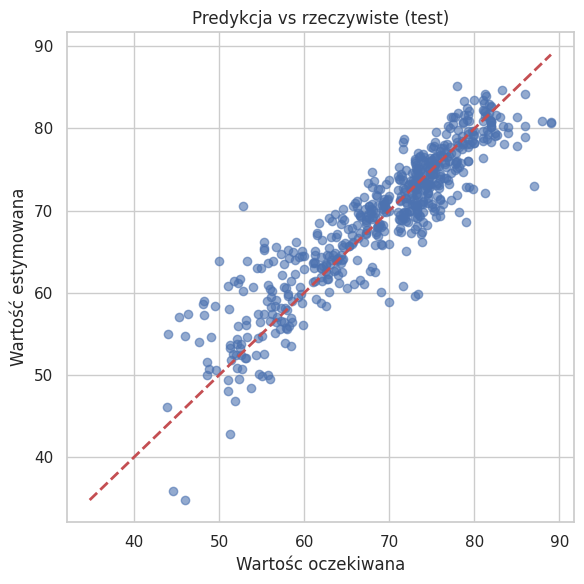

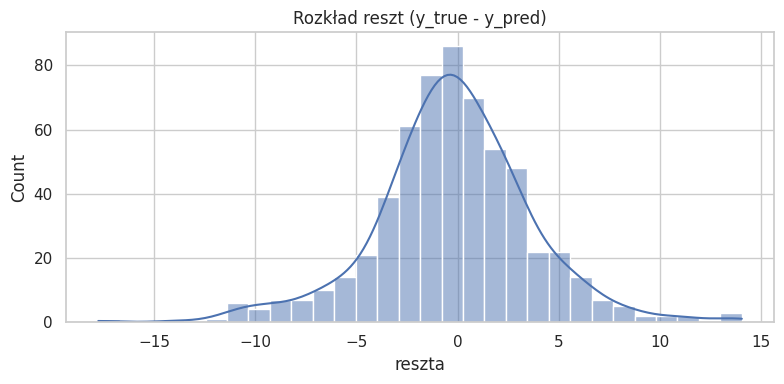

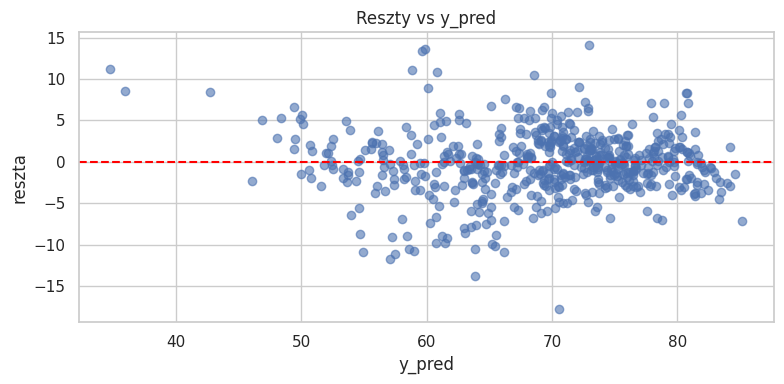

Reszty: średnia= -0.2196072178734923 std= 3.8854763319708203


In [39]:
# 11) Wykresy błędów na teście

# 1) Uczymy model na train (po przygotowaniu danych) i przewidujemy na teście
best_model.fit(X_train_t, y_train)
y_pred = best_model.predict(X_test_t)

# 2) Reszty (błędy): dodatnie = model zaniżył, ujemne = model zawyżył
residuals = y_test - y_pred

# Wykres 1: y_true vs y_pred (idealnie punkty leżą na przekątnej)
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
min_v = min(y_test.min(), y_pred.min())
max_v = max(y_test.max(), y_pred.max())
plt.plot([min_v, max_v], [min_v, max_v], "r--", linewidth=2)
plt.xlabel("Wartośc oczekiwana")
plt.ylabel("Wartość estymowana")
plt.title("Predykcja vs rzeczywiste (test)")
plt.tight_layout()
plt.show()

# Wykres 2: rozkład reszt (czy jest symetryczny wokół 0?)
plt.figure(figsize=(8, 4))
sns.histplot(residuals, kde=True, bins=30)
plt.title("Rozkład reszt (y_true - y_pred)")
plt.xlabel("reszta")
plt.tight_layout()
plt.show()

# Wykres 3: reszty vs y_pred (czy błąd zależy od poziomu predykcji?)
plt.figure(figsize=(8, 4))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color="red", linestyle="--")
plt.title("Reszty vs y_pred")
plt.xlabel("y_pred")
plt.ylabel("reszta")
plt.tight_layout()
plt.show()

print("Reszty: średnia=", float(np.mean(residuals)), "std=", float(np.std(residuals)))

## 12) Ważność cech: współczynniki modelu liniowego

W tej wersji (MED-style) nie robimy permutation importance. Zamiast tego:
- dla modeli liniowych (LinearRegression/Ridge) bierzemy współczynniki `coef_`,
- patrzymy na wartości bezwzględne $|coef|$ i pokazujemy TOP zmiennych.

To jest prosta, czytelna interpretacja – pamiętaj tylko, że dotyczy modelu liniowego i jest sensowna dzięki wcześniejszemu skalowaniu cech numerycznych.

,feature,coef,abs_coef
0,under-five deaths,-11.058112,11.058112
1,infant deaths,10.867040,10.867040
2,Adult Mortality,-2.603276,2.603276
3,HIV/AIDS,-2.423268,2.423268
4,Schooling,2.101076,2.101076
5,Income composition of resources,1.219401,1.219401
6,Diphtheria,0.988764,0.988764
7,Status_Developed,0.833315,0.833315
8,Status_Developing,-0.833315,0.833315
9,BMI,0.816837,0.816837


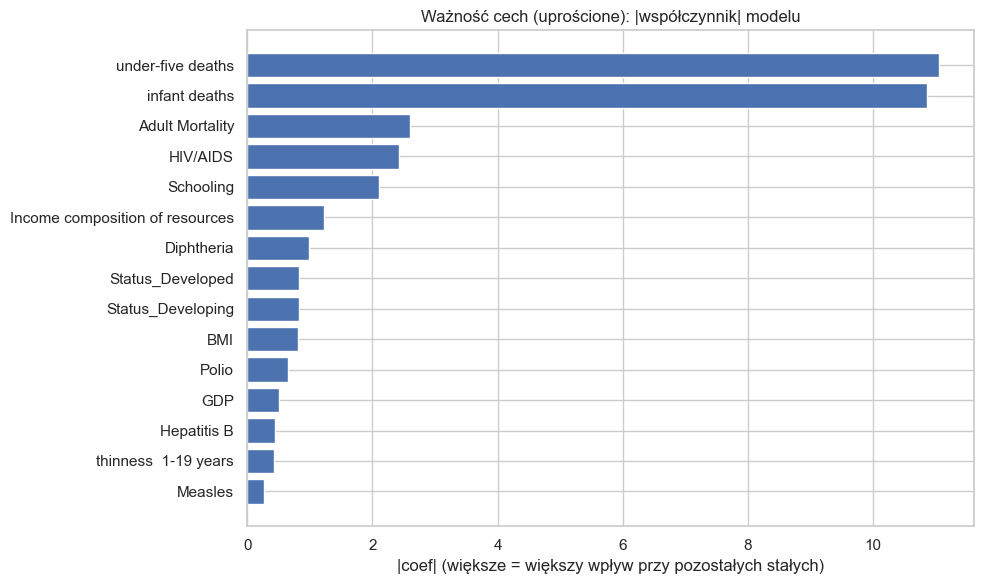

In [13]:
# 12) "Ważność" cech – uproszczone: współczynniki modelu liniowego

# Dla LinearRegression i Ridge mamy współczynniki coef_.
best_model.fit(X_train_t, y_train)

feature_names = np.array(preprocess_bundle.get("feature_names", []), dtype=object)
coefs = np.array(best_model.coef_, dtype=float)

coef_df = (
    pd.DataFrame({
        "feature": feature_names,
        "coef": coefs,
        "abs_coef": np.abs(coefs),
    })
    .sort_values("abs_coef", ascending=False)
    .reset_index(drop=True)
 )

display(coef_df.head(20))

plt.figure(figsize=(10, 6))
topk = coef_df.head(15).iloc[::-1]
plt.barh(topk["feature"], topk["abs_coef"])
plt.title("Ważność cech (uprościone): |współczynnik| modelu")
plt.xlabel("|coef| (większe = większy wpływ przy pozostałych stałych)")
plt.tight_layout()
plt.show()

## 14) Sprawdzenie uogólniania: podział po krajach (Country-holdout)

W danych mamy układ **kraj–rok**. Przy zwykłym losowym podziale wierszy ten sam kraj zwykle trafia i do train, i do test, co może **zawyżać wynik** (model „zna” już ten kraj).

Dlatego robimy prosty test uogólniania:
- losujemy ~80% **krajów** do train, a pozostałe kraje zostają w teście,
- trenujemy model na wierszach z krajów-treningowych,
- sprawdzamy metryki na *innych krajach* (bardziej realistycznie).

Ważne: nadal **nie używamy `Country` jako cechy** — `Country` służy tu tylko do zrobienia podziału.

In [14]:
# 14) Country-holdout – prosty test uogólniania (inne kraje w teście)

# Cel: sprawdzić, czy model działa na "nowych" krajach, a nie tylko na tych, które widział w treningu.
# Uwaga: Country NIE jest cechą modelu – używamy go wyłącznie do podziału danych.

_df = df.copy()
_df.columns = _df.columns.str.strip()

# y (target) jako liczby; wiersze z brakującym y usuwamy (nie da się na nich uczyć/oceniać)
y_all = pd.to_numeric(_df[TARGET_COL], errors="coerce")
mask = y_all.notna()

# X: cechy bez Country
X_all = _df.drop(columns=[TARGET_COL, "Country"], errors="ignore").loc[mask].reset_index(drop=True)
y_all = y_all.loc[mask].reset_index(drop=True)

# grupa = kraj (potrzebne tylko do podziału)
groups = _df.loc[mask, "Country"].reset_index(drop=True)

# 1) Losujemy kraje do train/test (80/20)
unique_countries = groups.unique()
rng = np.random.RandomState(RANDOM_STATE)
rng.shuffle(unique_countries)

cut = int(0.8 * len(unique_countries))
train_countries = set(unique_countries[:cut])
is_train = groups.isin(train_countries)

# 2) Składamy zbiory na podstawie krajów
X_train_c = X_all.loc[is_train].reset_index(drop=True)
y_train_c = y_all.loc[is_train].reset_index(drop=True)
X_test_c = X_all.loc[~is_train].reset_index(drop=True)
y_test_c = y_all.loc[~is_train].reset_index(drop=True)

print("Country-holdout:")
print("- train rows:", X_train_c.shape, "test rows:", X_test_c.shape)
print("- train countries:", len(train_countries), "test countries:", len(unique_countries) - len(train_countries))

# 3) Przygotowanie danych (tak samo jak w kroku 6, ale dopasowane TYLKO na train_c)
numeric_features_c = X_train_c.select_dtypes(include=["number"]).columns.tolist()
categorical_features_c = [c for c in X_train_c.select_dtypes(include=["object"]).columns.tolist() if c == "Status"]

num_imputer_c = SimpleImputer(strategy="median")
scaler_c = StandardScaler()
cat_imputer_c = SimpleImputer(strategy="most_frequent")
try:
    ohe_c = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe_c = OneHotEncoder(handle_unknown="ignore", sparse=False)

# numeryczne: fit na train, potem transform train/test
X_train_num = scaler_c.fit_transform(num_imputer_c.fit_transform(X_train_c[numeric_features_c]))
X_test_num = scaler_c.transform(num_imputer_c.transform(X_test_c[numeric_features_c]))

# kategoryczne (Status): fit na train, potem transform train/test
if len(categorical_features_c) > 0:
    X_train_cat = ohe_c.fit_transform(cat_imputer_c.fit_transform(X_train_c[categorical_features_c]))
    X_test_cat = ohe_c.transform(cat_imputer_c.transform(X_test_c[categorical_features_c]))
else:
    X_train_cat = np.empty((len(X_train_c), 0))
    X_test_cat = np.empty((len(X_test_c), 0))

X_train_ct = np.hstack([X_train_num, X_train_cat])
X_test_ct = np.hstack([X_test_num, X_test_cat])

# 4) Porównanie modeli na trudniejszym teście (prosto: LinearRegression vs Ridge)
country_results = []
country_results.append(evaluate_estimator(LinearRegression(), X_train_ct, X_test_ct, y_train_c, y_test_c, "LinearRegression"))
country_results.append(evaluate_estimator(Ridge(alpha=1.0, random_state=RANDOM_STATE), X_train_ct, X_test_ct, y_train_c, y_test_c, "Ridge(alpha=1.0)"))

display(pd.DataFrame(country_results).sort_values("RMSE"))

Country-holdout:
- train rows: (2336, 20) test rows: (592, 20)
- train countries: 146 test countries: 37


,model,MAE,RMSE,R2
0,LinearRegression,3.353027,4.346176,0.801031
1,Ridge(alpha=1.0),3.375199,4.382200,0.797719


## 15) Zapis: model + przygotowanie danych 

Zapisujemy bundle z:
- dopasowanymi transformatorami przygotowania danych (`preprocess_bundle`),
- najlepszym modelem (`best_model`).

In [15]:
# 15) Bundle (model + przygotowanie danych) + przykład predykcji (BEZ zapisu na dysk)

# Zgodnie z wymaganiem: w tym kroku nie tworzymy żadnych dodatkowych plików.
# Bundle trzymamy tylko w pamięci (możesz go ewentualnie zapisać ręcznie w innym miejscu, jeśli będzie potrzebne).

bundle = {
    "preprocess_bundle": preprocess_bundle,
    "model": best_model,
}

# Przykład: predykcja dla kilku wierszy z testu
sample = X_test.head(5)
sample_t = transform_preprocess(bundle["preprocess_bundle"], sample)
preds = bundle["model"].predict(sample_t)

preview = pd.DataFrame({
    "y_true": y_test.loc[sample.index].values,
    "y_pred": preds,
})
preview["abs_error"] = np.abs(preview["y_true"] - preview["y_pred"])
display(preview)

,y_true,y_pred,abs_error
0,73.7,67.141460,6.558540
1,75.9,77.258629,1.358629
2,74.2,75.671570,1.471570
3,76.8,78.093997,1.293997
4,51.9,46.860332,5.039668


## 16) Wnioski do sprawozdania 

- **Wyniki są spójne z EDA**: zależności są w dużej mierze liniowe → modele liniowe osiągają sensowne metryki (dla losowego splitu ok. $R^2\approx 0.83$ i RMSE ok. $3.9$ lat).
- **LinearRegression i Ridge dają bardzo podobne rezultaty**: w tej wersji najlepszy wg RMSE na teście jest `LinearRegression` (RMSE ≈ 3.892), a `Ridge(alpha=1.0)` jest minimalnie gorszy (RMSE ≈ 3.896). Różnice są marginalne, więc regularyzacja nie zmienia tu mocno jakości predykcji.
- **Przygotowanie danych jest kluczowe**: imputacja braków + skalowanie cech numerycznych + One-Hot dla `Status` umożliwia trening bez utraty dużej części danych (która wypadłaby przy `dropna`).
- **Współczynniki modelu** (wartości bezwzględne) pozwalają prosto wskazać, które zmienne najsilniej wpływają na przewidywania w modelu liniowym.
- **Test country-holdout** (inne kraje w teście) jest trudniejszy i pogarsza metryki względem losowego splitu: RMSE rośnie do ok. $4.35$, a $R^2$ spada do ok. $0.80$, co jest typowe dla danych kraj–rok.